# Data Exploration

In [53]:
# Import all required packages/libraries

import numpy as np
import cv2
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimg
from ipywidgets import interact, interactive, fixed

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from skimage.feature import hog

from mpl_toolkits.mplot3d import Axes3D
from functools import partial

# Import everything needed to edit/save/watch video clips
from moviepy.editor import ImageSequenceClip, VideoFileClip
from IPython.display import HTML

%matplotlib inline

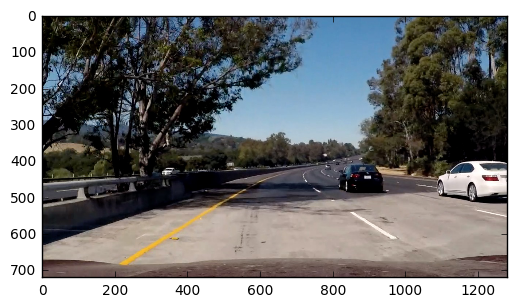

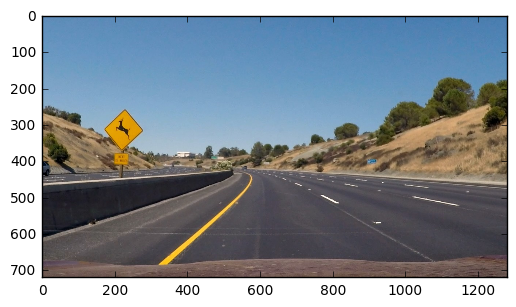

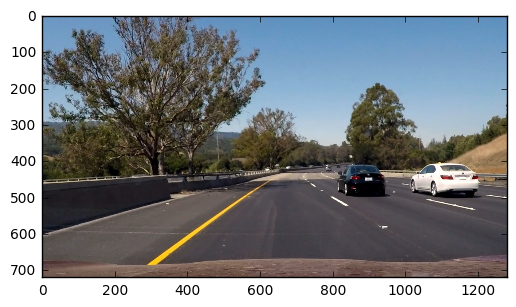

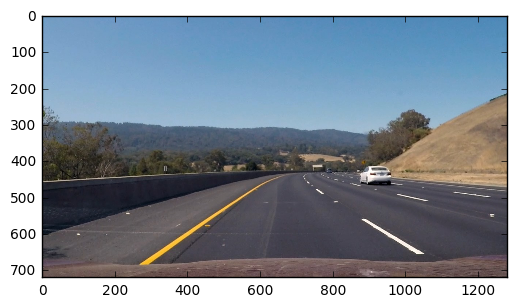

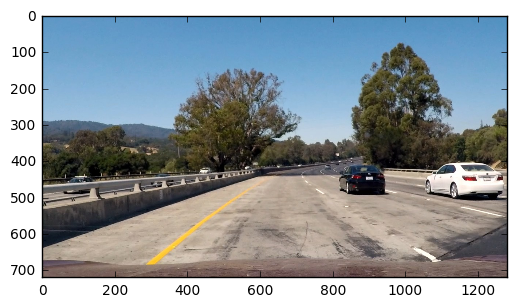

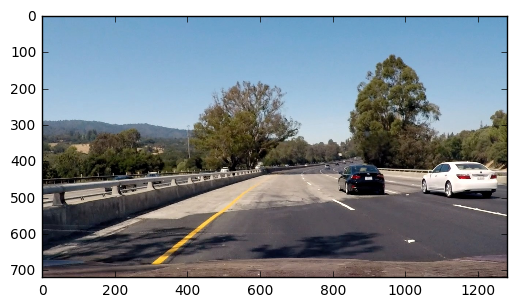

In [54]:
# Load test images
test_images = []
test_images_files = []

glob_test='test_images/*.jpg'

for file in glob.glob(glob_test):
    img = mpimg.imread(file)
    test_images.append(img)
    test_images_files.append(file)
    plt.imshow(img)
    plt.show()

#plt.axis('off');


In [55]:
# Load cars/non-cars images from dataset
non_vehicle_sub_dirs=['Extras', 'GTI']
vehicle_sub_dirs=['GTI_Far', 'GTI_Left','GTI_MiddleClose','GTI_Right','KITTI_extracted']
non_vehicle_paths = ['non-vehicles/' + p for p in non_vehicle_sub_dirs]
vehicle_paths = ['vehicles/' + p for p in vehicle_sub_dirs]

def load_images(glob_regex='var/non-vehicles/Extras/*.png'):

    images = []
    files = []
    for f in glob.glob(glob_regex):
        img = cv2.imread(f)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
        files.append(f)

    return np.array(images), np.array(files)


def images_from_path(path):
    images, files = load_images(glob_regex=path + '/*.png')
    print("Path: ",path,"      Found:", len(files), "Images with shape:", images.shape)
    return images


non_vehicle_images = np.concatenate([images_from_path(p) for p in non_vehicle_paths], axis=0)
vehicle_images = np.concatenate([images_from_path(p) for p in vehicle_paths], axis=0)



Path:  non-vehicles/Extras       Found: 5068 Images with shape: (5068, 64, 64, 3)
Path:  non-vehicles/GTI       Found: 3900 Images with shape: (3900, 64, 64, 3)
Path:  vehicles/GTI_Far       Found: 834 Images with shape: (834, 64, 64, 3)
Path:  vehicles/GTI_Left       Found: 909 Images with shape: (909, 64, 64, 3)
Path:  vehicles/GTI_MiddleClose       Found: 419 Images with shape: (419, 64, 64, 3)
Path:  vehicles/GTI_Right       Found: 664 Images with shape: (664, 64, 64, 3)
Path:  vehicles/KITTI_extracted       Found: 5966 Images with shape: (5966, 64, 64, 3)


## Vehicle Images samples

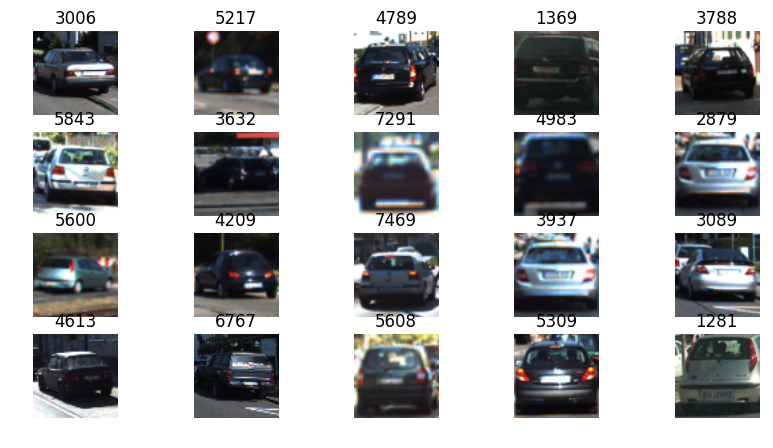

In [56]:
# Display samples of the vehicle data
plt.figure(figsize = (10,5))

for i in range(20):
    rand = np.random.randint(0, len(vehicle_images))
    
    # Display 
    plt.subplot(4,5,i+1)
    plt.imshow(vehicle_images[rand])
    plt.title(rand)
    
    
    plt.axis('off');
    plt.savefig("output_images/example_vehicle_data_images.jpg")
    

    

## Non-Vehicle Images samples

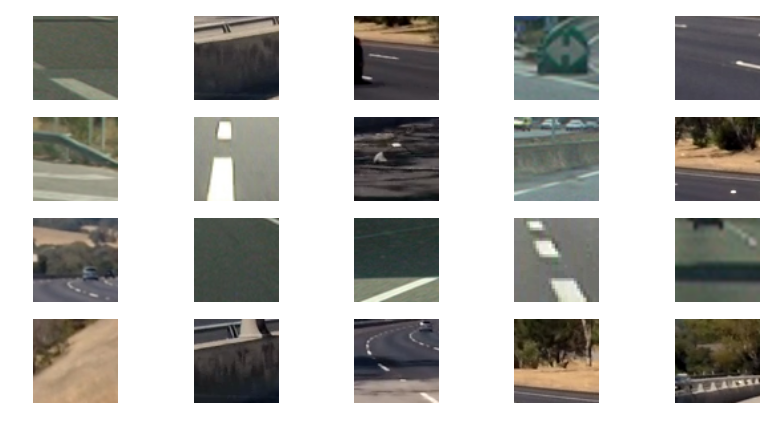

In [57]:
# Display samples of the non-vehicle data
plt.figure(figsize = (10,5))

for i in range(20):
    rand = np.random.randint(0, len(non_vehicle_images))
    
    # Display 
    plt.subplot(4,5,i+1)
    plt.imshow(non_vehicle_images[rand])
    
    plt.axis('off');
    plt.savefig("output_images/example_non_vehicle_data_images.jpg")
    
    

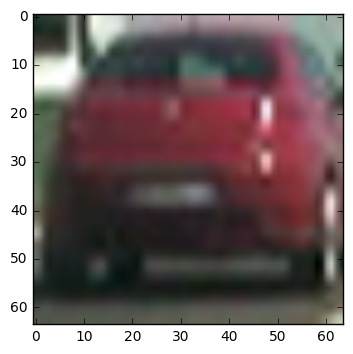

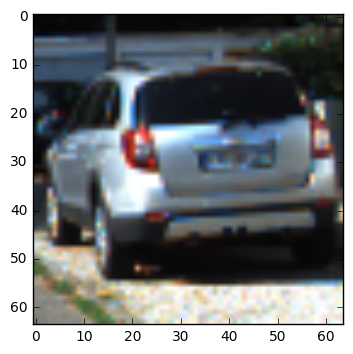

In [58]:
# Choose vehicle image to explore
img1 = vehicle_images[86]
img2 = vehicle_images[4236]

plt.imshow(img1)
plt.savefig("output_images/image_example_1.jpg")
plt.show()

plt.imshow(img2)
plt.savefig("output_images/image_example_2.jpg")

## Spatial binning

### Perform spatial binning on an image and still retain enough information to help in finding vehicles.

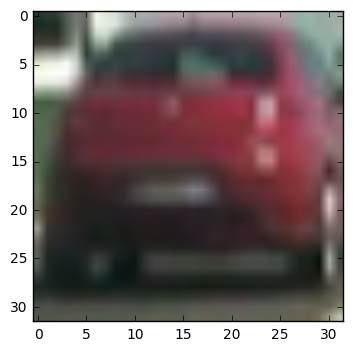

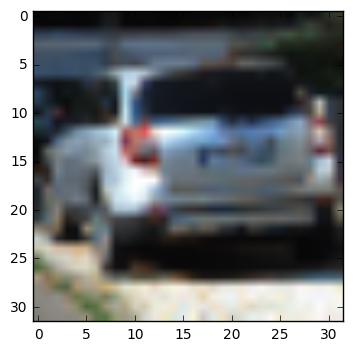

In [59]:
# Spatial Binning
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)
    # Use cv2.resize().ravel() to create the feature vector
    feature_image = cv2.resize(feature_image, size)

    return feature_image


plt.imshow(bin_spatial(img1, color_space='RGB', size=(32, 32)))
plt.savefig("output_images/image_example_1_spatial_binning.jpg")
plt.show()
plt.imshow(bin_spatial(img2, color_space='RGB', size=(32, 32)))
plt.savefig("output_images/image_example_2_spatial_binning.jpg")

## Color histogram feature

### Apply a color transform and append binned color features using YCbCr color space.

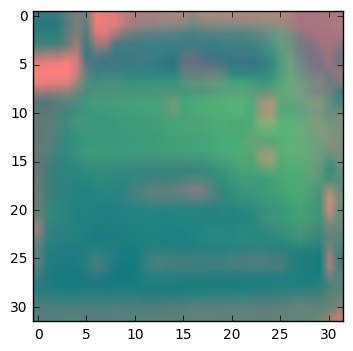

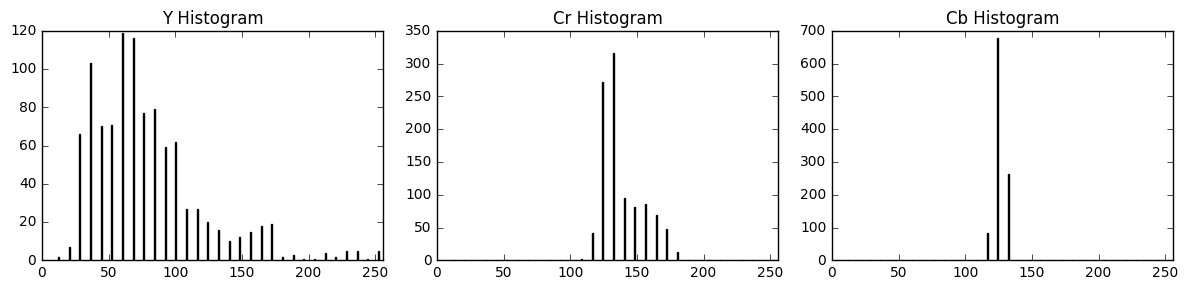

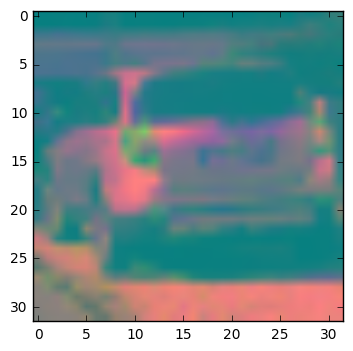

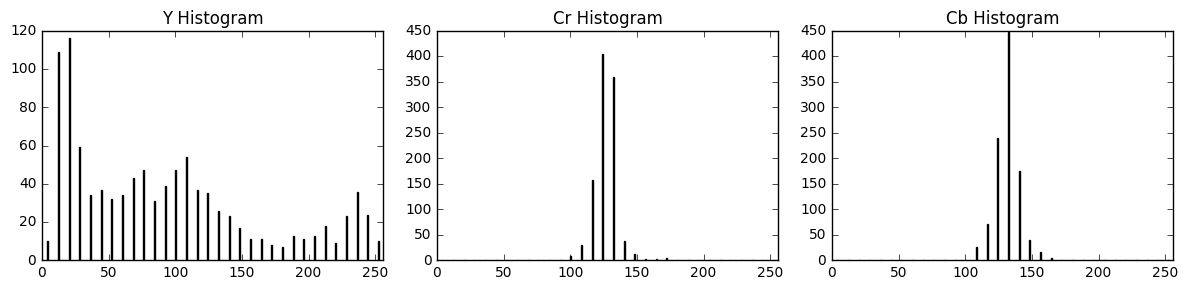

In [60]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the YCbCr channels separately
    Yhist = np.histogram(img[:,:,0], bins=32, range=(0, 256))
    Crhist = np.histogram(img[:,:,1], bins=32, range=(0, 256))
    Cbhist = np.histogram(img[:,:,2], bins=32, range=(0, 256))
    # Generating bin centers
    bin_edges = Yhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2

    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((Yhist[0], Crhist[0], Cbhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return Yhist, Crhist, Cbhist, bin_centers, hist_features


image = bin_spatial(img1, color_space='YCrCb', size=(32, 32))

Y, Cr, Cb, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))


plt.imshow(image)

plt.savefig("output_images/image_example_1_YCrCb.jpg")
plt.show()

# Plot a figure with all three bar charts
if Y is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, Y[0])
    plt.xlim(0, 256)
    plt.title('Y Histogram')
    plt.subplot(132)
    plt.bar(bincen, Cr[0])
    plt.xlim(0, 256)
    plt.title('Cr Histogram')
    plt.subplot(133)
    plt.bar(bincen, Cb[0])
    plt.xlim(0, 256)
    plt.title('Cb Histogram')
    fig.tight_layout()
    plt.savefig("output_images/image_example_1_YCrCb_Histogram.jpg")
    plt.show()
    
    
    
image = bin_spatial(img2, color_space='YCrCb', size=(32, 32))

Y, Cr, Cb, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))


plt.imshow(image)
plt.savefig("output_images/image_example_2_YCrCb.jpg")
plt.show()

# Plot a figure with all three bar charts
if Y is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, Y[0])
    plt.xlim(0, 256)
    plt.title('Y Histogram')
    plt.subplot(132)
    plt.bar(bincen, Cr[0])
    plt.xlim(0, 256)
    plt.title('Cr Histogram')
    plt.subplot(133)
    plt.bar(bincen, Cb[0])
    plt.xlim(0, 256)
    plt.title('Cb Histogram')
    fig.tight_layout()
    plt.savefig("output_images/image_example_2_YCrCb_Histogram.jpg")
    plt.show()

## Histogram of Oriented Gradients (HOG) feature
### HOG on the YCbCr color space. with 10 orientations, 8 pixels per cell and 2 cells per block

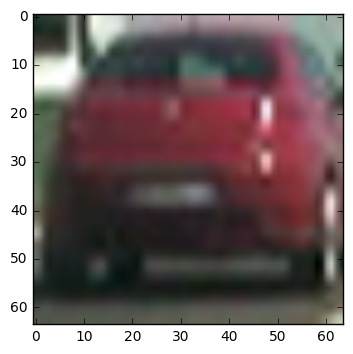

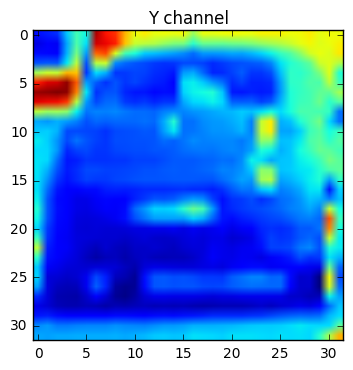

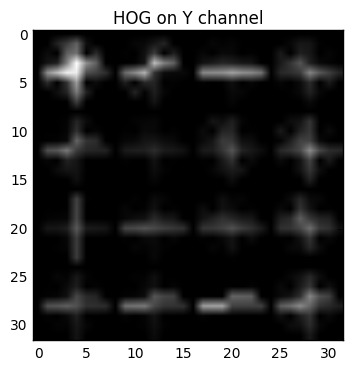

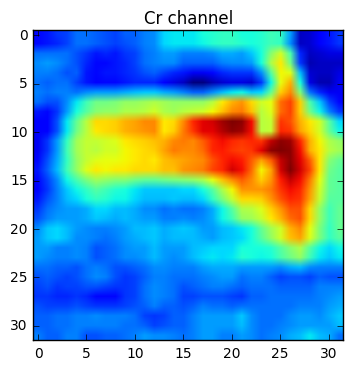

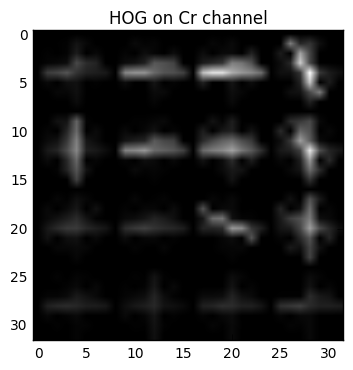

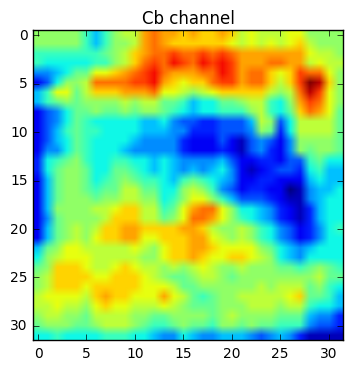

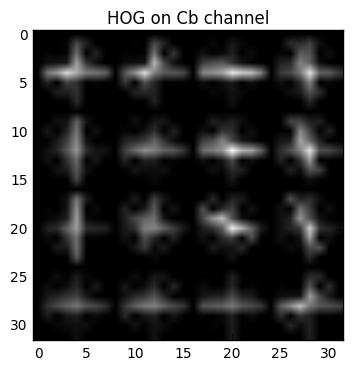

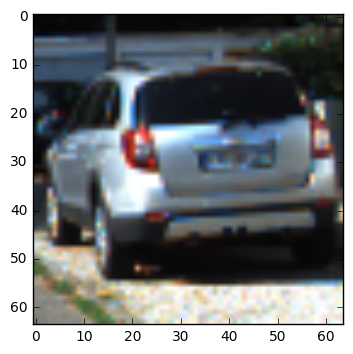

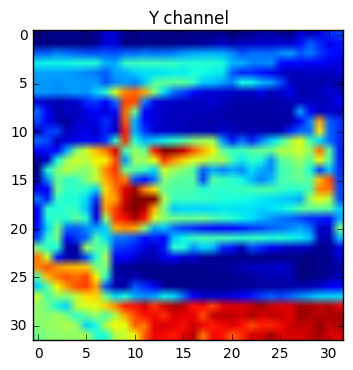

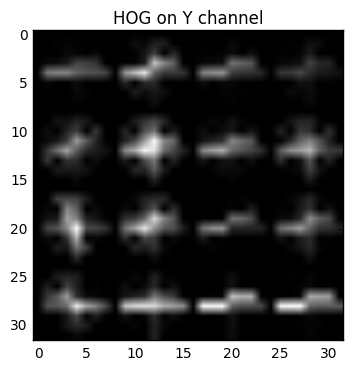

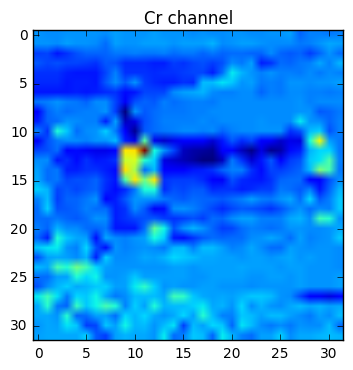

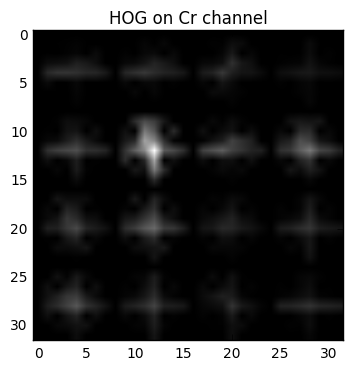

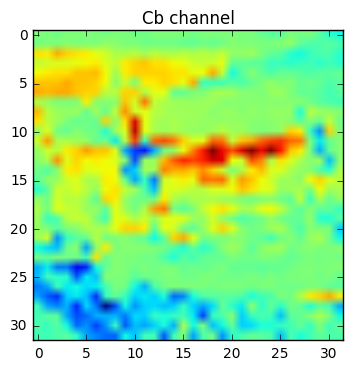

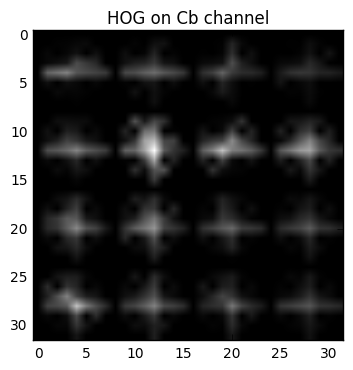

In [61]:
pix_per_cell = 8
cell_per_block = 2
orient = 10

plt.imshow(img1)
plt.show()

image =   bin_spatial(img1, color_space='YCrCb', size=(32, 32))

features, hog_image1 = hog(image[:,:,0], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)

plt.title("Y channel")
plt.imshow(image[:,:,0])
plt.savefig("output_images/image_example_1_Y_channel.jpg")
plt.show()
plt.title("HOG on Y channel")
plt.imshow(hog_image1, cmap = 'gray')
plt.savefig("output_images/image_example_1_Y_channel_HOG.jpg")
plt.show()

features, hog_image1 = hog(image[:,:,1], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)

plt.title("Cr channel")
plt.imshow(image[:,:,1])
plt.savefig("output_images/image_example_1_Cr_channel.jpg")
plt.show()
plt.title("HOG on Cr channel")
plt.imshow(hog_image1, cmap = 'gray')
plt.savefig("output_images/image_example_1_Cr_channel_HOG.jpg")
plt.show()


features, hog_image1 = hog(image[:,:,2], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)

plt.title("Cb channel")
plt.imshow(image[:,:,2])
plt.savefig("output_images/image_example_1_Cb_channel.jpg")
plt.show()
plt.title("HOG on Cb channel")
plt.imshow(hog_image1, cmap = 'gray')
plt.savefig("output_images/image_example_1_Cb_channel_HOG.jpg")
plt.show()



plt.imshow(img2)
plt.show()

image = bin_spatial(img2, color_space='YCrCb', size=(32, 32))

features, hog_image1 = hog(image[:,:,0], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)

plt.title("Y channel")
plt.imshow(image[:,:,0])
plt.savefig("output_images/image_example_2_Y_channel.jpg")
plt.show()
plt.title("HOG on Y channel")
plt.imshow(hog_image1, cmap = 'gray')
plt.savefig("output_images/image_example_2_Y_channel_HOG.jpg")
plt.show()

features, hog_image1 = hog(image[:,:,1], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)

plt.title("Cr channel")
plt.imshow(image[:,:,1])
plt.savefig("output_images/image_example_2_Cr_channel.jpg")
plt.show()
plt.title("HOG on Cr channel")
plt.imshow(hog_image1, cmap = 'gray')
plt.savefig("output_images/image_example_2_Cr_channel_HOG.jpg")
plt.show()


features, hog_image1 = hog(image[:,:,2], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)

plt.title("Cb channel")
plt.imshow(image[:,:,2])
plt.savefig("output_images/image_example_2_Cb_channel.jpg")
plt.show()
plt.title("HOG on Cb channel")
plt.imshow(hog_image1, cmap = 'gray')
plt.savefig("output_images/image_example_2_Cb_channel_HOG.jpg")
plt.show()

## Combine and Normalize Features

### Combination of HOG (Histogram of Oriented Gradients), spatial information and color channel histograms, all using YCbCr color space.

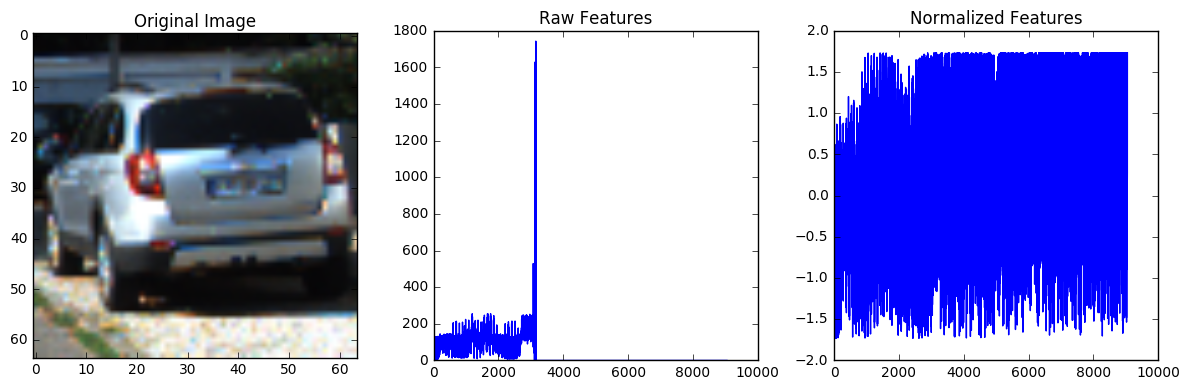

In [62]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features


# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
# 10 orientations, 8 pixels per cell and 2 cells per block
def extract_features(imgs, color_space='YCbCr', spatial_size=(32, 32),
                        hist_bins=32, orient=10, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img in imgs:
        file_features = []
        # Read in each one by one
        image = img
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# take our two sample images to extract features 
img1 = vehicle_images[86]
img2 = vehicle_images[4236]

cars = []
cars.append(img1)
cars.append(img2)

notcars = non_vehicle_images[0:2]


color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


# Extract car features
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Extract non-car features
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Features Normalization
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

car_ind = 1

# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(cars[car_ind])
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()
plt.savefig("output_images/example_Combined_normalized_features.jpg")
plt.show()

## Classifier Training

### Extracting Features

In [63]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t=time.time()
# Extract car features
car_features = extract_features(vehicle_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Extract non-car features
notcar_features = extract_features(non_vehicle_images, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')
print(len(car_features), ' Cars features')
print(len(notcar_features), 'Non_Car features')


91.49 Seconds to extract features...
8792  Cars features
8968 Non_Car features


### Classifier Training 

In [64]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

27.06 Seconds to train SVC...


### Testing Accuracy

In [65]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


Test Accuracy of SVC =  0.9938


# Sliding Window Search



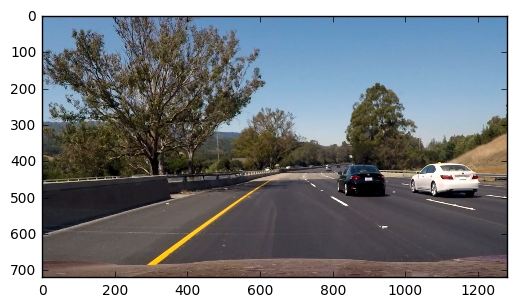

In [68]:
# load test image
image = cv2.imread('test_images/test6.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display image
plt.imshow(image)


## Creating search windows at several scales

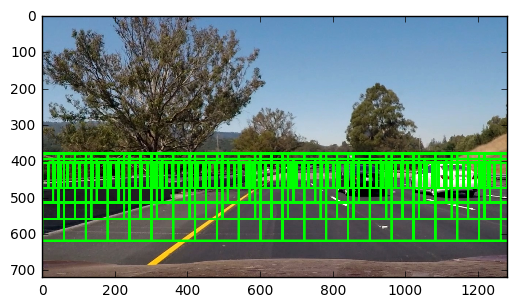

In [69]:

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 255 , 0), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Creating search windows at several scales

all_windows = []

X_start_stop =[[None,None],[None,None],[None,None],[None,None]]
XY_window = [(240,240),(180,180),(120,120),(70,70)]
XY_overlap = [(0.75,0.75),(0.75,0.75),(0.75,0.75),(0.75,0.75)]
Y_start_stop =[[380,380+240/2],[380,380+180/2],[395,395+120/2],[405,405+70/2]]



for i in range(len(Y_start_stop)):
    windows = slide_window(image, x_start_stop=X_start_stop[i], y_start_stop=Y_start_stop[i], 
                            xy_window=XY_window[i], xy_overlap=XY_overlap[i])

    all_windows += [windows] 
    

windows_image = image
    
for window in all_windows:
    
    windows_image = draw_boxes(windows_image, window, thick=6)


# Display image

plt.imshow(windows_image)
plt.savefig("output_images/search_windows_different_scales.jpg")



### Applying Sliding Window Search on test image

Hot windows:
((810, 395), (930, 515))
((840, 395), (960, 515))
((990, 395), (1110, 515))
((1020, 395), (1140, 515))
((1050, 395), (1170, 515))
((1080, 395), (1200, 515))
((816, 405), (886, 475))
((833, 405), (903, 475))
((850, 405), (920, 475))
((867, 405), (937, 475))
((1020, 405), (1090, 475))
((1037, 405), (1107, 475))


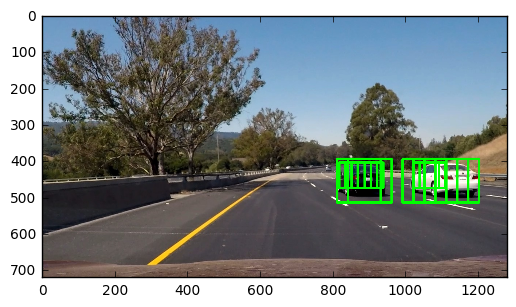

In [70]:

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


# Define a function to extract features from a single image window

def single_img_features(img, color_space='YCrCb', spatial_size=(32, 32),
                        hist_bins=32, orient=10, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)



# Searching hot windows in the image
# Define a function you will pass an image


def search_windows(img, windows, clf, scaler, color_space='YCrCb', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=10, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel='ALL', spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        #test_features = scaler.transform(np.array(features).reshape(1, -1))
        test_features = scaler.transform(features)

        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
            
    #8) Return windows for positive detections
    return on_windows

hot_windows = []


for windows in all_windows:
    
    hot_windows.append(search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat))


windows_image = image

print("Hot windows:")

for windows in hot_windows:
    for window in windows:
        print(window)
    windows_image = draw_boxes(windows_image, windows, thick=6)


# Display image

plt.imshow(windows_image)
plt.savefig("output_images/Hot_windows.jpg")
        
        

### Applying Sliding Window Search on test video


In [71]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


# finding cars in video frames

def find_cars(img):
    
    global all_windows
    
    hot_windows = []
    
    for windows in all_windows:
    
        hot_windows.append(search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat))
    
    windows_image = img
    
    for windows in hot_windows:
        windows_image = draw_boxes(windows_image, windows, thick=6)
        
        
    return windows_image


In [18]:
# Apply on the test video

#inpfile='test_video.mp4'
outfile='output_test_video_hot_windows.mp4'

clip = VideoFileClip('test_video.mp4', audio=False)

out_clip = clip.fl_image(find_cars) 

%time out_clip.write_videofile(outfile, audio=False)


[MoviePy] >>>> Building video output_test_video_hot_windows.mp4
[MoviePy] Writing video output_test_video_hot_windows.mp4


 97%|█████████▋| 38/39 [00:35<00:00,  1.09it/s]      | 1/39 [00:00<00:33,  1.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_test_video_hot_windows.mp4 

CPU times: user 35.2 s, sys: 116 ms, total: 35.3 s
Wall time: 37 s


## Filtering multiple detections & false positives

### Heat-map on test image

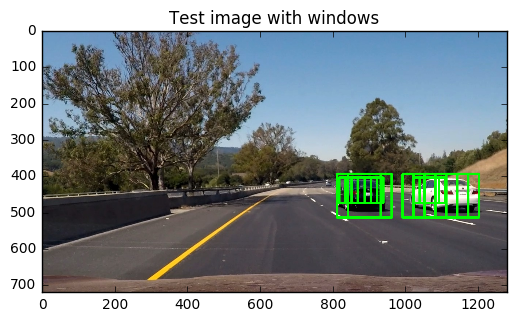

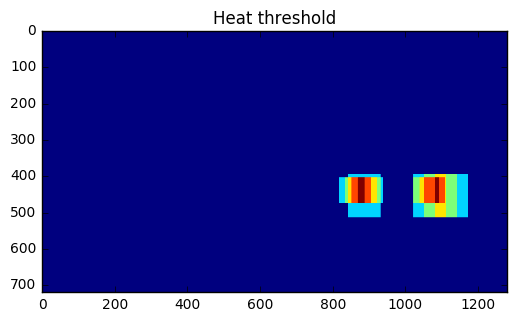

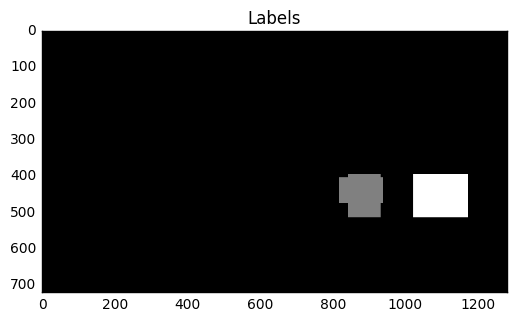

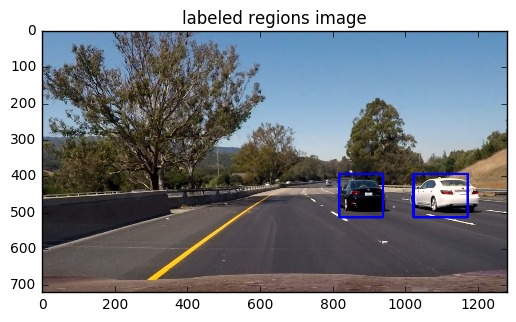

In [72]:
from scipy.ndimage.measurements import label



heat = np.zeros_like(image[:,:,0]).astype(np.float)
hot_windows = []
boxes = []

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    
    if bbox_list is not None:
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            if box is not None:
                heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img






for windows in all_windows:
    
    hot_windows.append(search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat))

for windows in hot_windows:
    for window in windows:
        boxes.append(window)
        
# Add heat to each box in box list
heat = add_heat(heat,boxes)
        

# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

#figuring out how many cars you have in each frame
labels = label(heat)


draw_img = draw_labeled_bboxes(np.copy(image), labels)


plt.imshow(windows_image)
plt.title("Test image with windows")
plt.show()

plt.imshow(heat)
plt.title("Heat threshold")
plt.savefig("output_images/heat_map.jpg")
plt.show()


plt.imshow(labels[0], cmap='gray')
plt.savefig("output_images/labeled_image.jpg")
plt.title("Labels")
plt.show()


plt.imshow(draw_img)
plt.title("labeled regions image")
plt.savefig("output_images/labeled_regions_image.jpg")
plt.show()


In [20]:
# trying what so far on the test video

def find_cars_labeled_regions(img):
    
    global all_windows
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    hot_windows = []
    boxes = []
    
    
    for windows in all_windows:

        hot_windows.append(search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat))    

    for windows in hot_windows:
        for window in windows:
            boxes.append(window)

    # Add heat to each box in box list
    heat = add_heat(heat,boxes)


    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    #figuring out how many cars you have in each frame
    labels = label(heat)


    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img
    
# Apply on the test video
outfile='output_test_video_labeled_regions.mp4'
clip = VideoFileClip('test_video.mp4', audio=False)
out_clip = clip.fl_image(find_cars_labeled_regions) 
out_clip.write_videofile(outfile, audio=False)


[MoviePy] >>>> Building video output_test_video_labeled_regions.mp4
[MoviePy] Writing video output_test_video_labeled_regions.mp4


 97%|█████████▋| 38/39 [00:35<00:00,  1.11it/s]      | 1/39 [00:00<00:35,  1.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_test_video_labeled_regions.mp4 



##  Implementing a FIFO queue that stores the bounding boxes of the last n frames.


In [97]:
from collections import deque

class Boxes:
    def __init__(self,n=20):
        # length of queue to store data
        self.n = n
        # hot windows of the last n images
        self.recent_boxes = deque([],maxlen=n)
        # current boxes
        self.current_boxes = None
        self.allboxes = []

    def add_boxes(self):
        self.recent_boxes.appendleft(self.current_boxes)
        
    def pop_data(self):        
        if self.n_buffered>0:
            self.recent_boxes.pop()            
    def set_current_boxes(self,boxes):
        self.current_boxes = boxes
        
    def get_all_boxes(self):        
        allboxes = []
        for boxes in self.recent_boxes:
            allboxes += boxes
        if len(allboxes)==0:
            self.allboxes = None
        else:
            self.allboxes = allboxes
            
    def update(self,boxes):
        self.set_current_boxes(boxes)
        self.add_boxes()
        self.get_all_boxes()
        


In [98]:
b_boxes = Boxes(n=20)

# function to find cars with stored history of the bounding boxes from previous frames
def find_cars_with_old_bboxes(img):
    
    global all_windows
    global b_boxes
    
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    hot_windows = []
    boxes = []
    
    
    for windows in all_windows:

        hot_windows.append(search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat))    

    for windows in hot_windows:
        for window in windows:
            boxes.append(window)
            
    b_boxes.update(boxes)   

    # Add heat to each box in boxes list
    heat = add_heat(heat,b_boxes.allboxes)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,20)

    #figuring out how many cars you have in each frame
    labels = label(heat)
    

    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img    

In [52]:
# Try on the test video 

outfile='output_test_video_with_queue_previous_frames.mp4'

clip = VideoFileClip('test_video.mp4', audio=False)

out_clip = clip.fl_image(find_cars_with_old_bboxes) 

%time out_clip.write_videofile(outfile, audio=False)

[MoviePy] >>>> Building video output_test_video_with_queue_previous_frames.mp4
[MoviePy] Writing video output_test_video_with_queue_previous_frames.mp4


 97%|█████████▋| 38/39 [00:35<00:00,  1.01it/s]      | 1/39 [00:00<00:33,  1.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_test_video_with_queue_previous_frames.mp4 

CPU times: user 35.3 s, sys: 292 ms, total: 35.6 s
Wall time: 37.2 s


In [99]:
# Applying on project video
b_boxes = Boxes(n=20)

outfile='output_project_video.mp4'

clip = VideoFileClip('project_video.mp4', audio=False)

out_clip = clip.fl_image(find_cars_with_old_bboxes) 

%time out_clip.write_videofile(outfile, audio=False)

[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|█████████▉| 1260/1261 [20:29<00:01,  1.07s/it]    | 1/1261 [00:00<17:57,  1.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

CPU times: user 20min 21s, sys: 3.21 s, total: 20min 25s
Wall time: 20min 30s
